In [2]:
from b1 import *
from urllib.request import urlopen
import json
import numpy as np
import pandas as pd
import os
import copy
import math
import statistics
import sklearn.metrics as metrics
 
# Evitar truncar data mostrada al usar jupyter notebook
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
 
# Constante que aloja el diccionario JSON con toda la data
DATA = None

# Obtener data JSON
if os.path.exists('./out/dataout.json'):
    DATA = json.load(open('./out/dataout.json', 'r'))
else:
    data_url = urlopen('http://nutriexcel.cl/UMDU/dataout_v2.json')
    DATA = json.loads(data_url.read())

In [3]:
#@title **Parameters**

# Objective vector
TARGET = 'np'
NORM_TYPE = 'col'
N_FEATURES = 5
 
 
# Import needed libraries ----------------------------------------
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
 
random_state = None # Random state for train_test_split

In [35]:
from sklearn.preprocessing import StandardScaler

cursos = ['7','13','19','24','30','36']
datalab_norm = []
for i in range(1,5):

    # CursoData retorna el curso de los alumnos del lab Correspondiente
    datalab_all,cursoData = get_custom_dataframe(DATA, [i], [TARGET], 'all', labels=True, index=None)

    #@title **Data preparation**

    datalab = copy.deepcopy(datalab_all)
    #print(datalab1_all)

    # Group columns
    datalab = apply(datalab, 'dis_lab'+str(i), norm_log, replace=True)
    datalab = apply(datalab, 'qat?', max, replace=False)
    datalab = apply(datalab, 'qat?', sum, replace=True)
    datalab = apply(datalab, 'max(qat$_lab'+str(i)+')', norm_log, replace=True)
    datalab = apply(datalab, 'sum(qat$_lab'+str(i)+')', norm_log, replace=True)
    datalab = apply(datalab, 'qmsr?', statistics.mean)
    datalab = datalab.round(4)

    # Se transforma a dataframe la info de ese curso en particular
    cursoDF = pd.DataFrame(cursoData,columns=['curso'])


    # Se concatenan los dos dataframes 
    dfFinlab = pd.concat([datalab,cursoDF],axis=1)

    first = True
    for curso in cursos:
        # Filtrar por curso
        dfLabCurso = pd.DataFrame(dfFinlab.loc[dfFinlab['curso']==curso])

        aux = dfLabCurso['mean(qmsr$_lab'+str(i)+')'].replace(0, (np.mean(dfLabCurso['mean(qmsr$_lab'+str(i)+')']))).copy()
        dfLabCurso['mean(qmsr$_lab'+str(i)+')']=aux


        scaler1 = StandardScaler()

        # Se obtiene la columna con el promedio del curso X
        promCurso = pd.DataFrame(dfLabCurso.reset_index()[TARGET])


        # Se obtiene los datos del curso X para el lab Y normalizados Excluyendo la fila mean(p$p2)
        # ------------               Función que normaliza la data      , el nombre de las col a colocar en el DF  [desde cual columna hasta cual]
        DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLabCurso),columns=dfLabCurso.columns)[dfLabCurso.columns[1:14]]

        datalabNormc = pd.concat([promCurso,DFnormalizado],axis=1)


        if first: datalab_norm.append(datalabNormc); first=False
        else: datalab_norm[i-1] = pd.concat([datalab_norm[i-1],datalabNormc], axis=0)

        datalab_norm[i-1] = datalab_norm[i-1].reset_index(drop = True)

#datalab1_norm

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


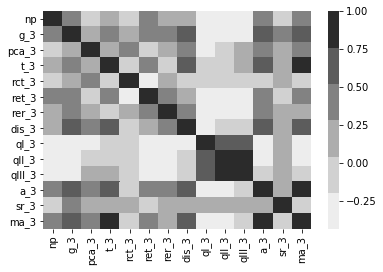

In [43]:
import seaborn as sn
import matplotlib.pyplot as plt
datalab = datalab_norm[2].set_axis(['np', 'g_3', 'pca_3', 't_3' ,'rct_3', 'ret_3', 'rer_3', 'dis_3', 'qI_3', 'qII_3', 'qIII_3', 'a_3', 'sr_3', 'ma_3'], axis=1)

corrMatrix = datalab_norm[2].corr()
sn.heatmap(corrMatrix, annot=False, cmap=sn.color_palette("Greys"))
plt.savefig("corr_lab3.png")
plt.show()


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


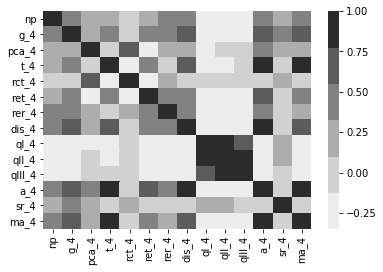

In [44]:
import seaborn as sn
import matplotlib.pyplot as plt
datalab = datalab_norm[3].set_axis(['np', 'g_4', 'pca_4', 't_4' ,'rct_4', 'ret_4', 'rer_4', 'dis_4', 'qI_4', 'qII_4', 'qIII_4', 'a_4', 'sr_4', 'ma_4'], axis=1)

corrMatrix = datalab_norm[3].corr()
sn.heatmap(corrMatrix, annot=False, cmap=sn.color_palette("Greys"))
plt.savefig("corr_lab4.png")
plt.show()


### MODELS

In [39]:
#@title **Grid/Random-SearchCV process**   
 
def run_process(dataset, grid_cv, target=TARGET):
    X, y = dataset.drop(target, axis=1), np.array(dataset[target])
   
    grid_cv.fit(X,y)
    print('R2:', max(grid_cv.cv_results_['mean_test_score']))
    
    try:
        selected_features = X.columns[grid_cv.best_estimator_.steps[0][-1].get_support()]
    except:
        return list(dataset.columns[1:])
    
    return list(selected_features)

In [40]:
#@title **Random Forest Regressor** 

from sklearn.ensemble import  RandomForestRegressor
 
estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
params = {
    'n_estimators'  : [50,100,200,400],
    'criterion'     : ['mse','mae'],
    'max_features'  : ['auto','sqrt','log2'],
    'max_depth'     : [5]
}
 
grid_rfr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [8]:
dataset = datalab_norm[2]
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
att_rfr=run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.2min finished


R2: 0.3111178224189947


In [24]:
dataset = datalab_norm[3]
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
att_rfr=run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.8min finished


R2: 0.14577809480691073


In [41]:
dataset = datalab_norm[2][datalab_norm[2].columns.delete(1)].join(datalab_norm[3][datalab_norm[3].columns.delete([0,1])])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
att_rfr=run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

### Conglomerado usando labs 2 y 3

In [73]:
from sklearn.ensemble import  RandomForestRegressor

estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
params = {
    'n_estimators'  : [50,100,200,400],
    'criterion'     : ['mse','mae'],
    'max_features'  : ['auto','sqrt','log2']
}
 
grid_rfr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [74]:
import b1
import importlib
importlib.reload(b1)
from b1 import *

dataset = datalab_norm[2].join(datalab_norm[3][datalab_norm[3].columns.delete([0])])
#remove_col(dataset, 'g?')
for col in dataset.columns:
    if col[-1]=='3':
        dataset = apply(dataset, [col[:-1]+'3',col[:-1]+'4'], np.mean)
print(dataset.columns)

Index(['np', 'mean(g_$)', 'mean(pca_$)', 'mean(t_$)', 'mean(rct_$)',
       'mean(ret_$)', 'mean(rer_$)', 'mean(dis_$)', 'mean(qI_$)',
       'mean(qII_$)', 'mean(qIII_$)', 'mean(a_$)', 'mean(sr_$)', 'mean(ma_$)'],
      dtype='object')


In [75]:
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
att_rfr=run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.3min finished


R2: 0.33206878736157497


In [84]:
sorted = np.argsort(-grid_rfr.best_estimator_.feature_importances_)
np.array([grid_rfr.best_estimator_.feature_importances_[i] for i in sorted])
np.array([[att_rfr[i],i,grid_rfr.best_estimator_.feature_importances_[i]] for i in sorted])

array([['mean(g_$)', '0', '0.19823765595914686'],
       ['mean(pca_$)', '1', '0.0916086568925645'],
       ['mean(qII_$)', '8', '0.09044946062143618'],
       ['mean(qIII_$)', '9', '0.09026084215503212'],
       ['mean(sr_$)', '11', '0.08207506213153386'],
       ['mean(qI_$)', '7', '0.0718628757897187'],
       ['mean(rer_$)', '5', '0.0701695650806905'],
       ['mean(rct_$)', '3', '0.05927393738777817'],
       ['mean(ret_$)', '4', '0.05870905007049707'],
       ['mean(dis_$)', '6', '0.05352792123243046'],
       ['mean(t_$)', '2', '0.04739251223320139'],
       ['mean(a_$)', '10', '0.04390044661550098'],
       ['mean(ma_$)', '12', '0.04253201383046907']], dtype='<U19')

In [83]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=50)
grid_rfr.best_estimator_.fit(X_train,y_train)
y = grid_rfr.best_estimator_.predict(X_test)

print(grid_rfr.best_estimator_.score(X_test,y_test))

0.43470915454817194


In [85]:
y

array([5.627  , 5.3475 , 4.0625 , 5.858  , 5.8745 , 5.0375 , 5.779  ,
       5.37925, 6.1085 , 6.207  , 5.7825 , 5.79775, 5.4835 , 6.245  ,
       3.5415 , 6.0735 , 6.234  , 5.491  , 6.433  , 6.225  , 6.0145 ,
       5.705  , 5.3985 , 5.8385 , 6.328  , 5.36475, 5.816  , 5.35725,
       5.6685 , 5.6965 , 5.349  , 5.537  , 5.67475, 5.903  , 5.76   ,
       5.63   , 5.8335 , 4.8145 , 5.678  , 5.37375, 6.5465 , 6.2    ,
       5.722  , 4.0405 , 4.45625, 5.461  , 5.4755 , 5.7415 , 5.809  ,
       5.77525, 5.8265 , 5.3885 , 4.3045 , 4.534  , 5.1655 , 5.612  ,
       5.82175, 6.1485 , 5.879  , 5.7085 , 5.7285 , 5.9915 , 3.943  ,
       6.213  , 6.186  , 6.3285 , 5.413  , 5.651  , 5.1385 , 4.64925,
       4.9595 , 4.1735 , 4.9255 , 5.381  , 5.7215 , 5.3005 , 5.87475,
       5.566  ])

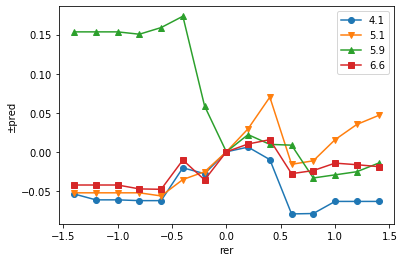

In [101]:
import matplotlib.pyplot as plt
Y = X_test.values.copy()

t = np.arange(-1.4, 1.6, 0.2)
att=5
att_label='rer'
plt.xlabel(att_label) 
plt.ylabel('±pred') 


for i in [[2,'o-'],[5,'v-'],[8,'^-'],[40,'s-']]:
    Y[i[0]][att] = 0
    r=grid_rfr.best_estimator_.predict([Y[i[0]]])
    
    ft = [grid_rfr.best_estimator_.predict([Y[i[0]]])-r for Y[i[0]][att] in t ]
    plt.plot(t,ft, i[1], label=str("%.1f" % r))


plt.legend()

plt.savefig(att_label+'.pdf')
plt.show()

### Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()
 
params = {
    'n_jobs'    : [-1],
}
 
grid_lr = GridSearchCV(estimator=estimator,
                       param_grid=params,
                       scoring='r2',
                       verbose=1,
                       n_jobs=-1,
                       return_train_score=True,
                       cv=KFold(n_splits=10, shuffle=False))

In [62]:
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
att=run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.27148398566677123


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


In [106]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
#X = X[X.columns.delete(0)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)

grid_lr.best_estimator_.fit(X_train,y_train)
ypred = grid_lr.best_estimator_.predict(X_test)
grid_lr.best_estimator_.score(X_test,y_test)

0.32956797110950387

In [107]:
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     13.45
Date:                Wed, 14 Jul 2021   Prob (F-statistic):           9.41e-22
Time:                        18:37:39   Log-Likelihood:                -276.93
No. Observations:                 234   AIC:                             581.9
Df Residuals:                     220   BIC:                             630.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.4973      0.054    102.351   

C:\Users\Dell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [104]:
sorted = np.argsort(-abs(grid_lr.best_estimator_.coef_))
[grid_lr.best_estimator_.coef_[i] for i in sorted]
[[att[i],grid_lr.best_estimator_.coef_[i]] for i in sorted]

TypeError: 'int' object is not subscriptable